# JAX Demo

We'll first load up MNIST using PyTorch's dataloading API and the cpu-only wheel. We cast the torch tensors to jnp arrays in our collate function and flatten the images into vectors for compatibility with the MLP.

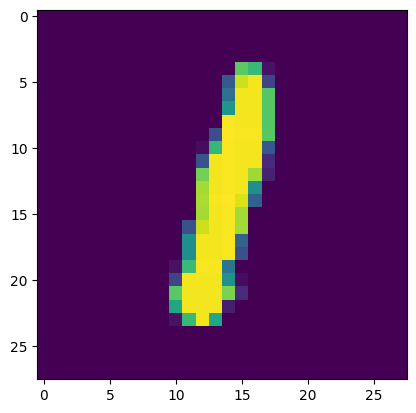

In [46]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, default_collate

import jax.numpy as jnp # jax implementations of numpy api
import matplotlib.pyplot as plt # to show images

mnist_train = datasets.MNIST(root="./data/", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root="./data/", train=False, download=True, transform=transforms.ToTensor())

# function to turn a batch of PyTorch data into a batch of JAX arrays
def jnp_collate(batch):
    x, y = default_collate(batch)
    x = jnp.asarray(x).reshape(x.shape[0], -1)
    y = jnp.asarray(y)
    return x, y

train_ds = DataLoader(mnist_train, batch_size=128, shuffle=True, collate_fn=jnp_collate)
test_ds = DataLoader(mnist_test, batch_size=128, shuffle=False, collate_fn=jnp_collate)

sample_data, sample_labels = next(iter(train_ds))
sample_img = sample_data[-1]

# show the last image
plt.imshow(sample_img.reshape(28, 28))

With the data loaded and preprocessed, we can define our model and make a test instance.

In [47]:
from flax import nnx

class MLP(nnx.Module):
    def __init__(self, in_dim = 1 * 28 * 28, out_dim = 10, hidden_dim = 128, num_hidden_layers = 3, rngs = None):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.num_hidden_layers = num_hidden_layers
        
        self.layers = [
            nnx.Linear(in_dim, hidden_dim, rngs=rngs),
            nnx.relu,
        ]

        for _ in range(num_hidden_layers):
            self.layers.extend([
                nnx.Linear(hidden_dim, hidden_dim, rngs=rngs),
                nnx.relu
            ])

        self.layers.append(nnx.Linear(hidden_dim, out_dim, rngs=rngs))
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = MLP(in_dim = 784, out_dim = 10, hidden_dim = 128, num_hidden_layers = 3, rngs=nnx.Rngs(0)) 
model

MLP(
  in_dim=784,
  out_dim=10,
  hidden_dim=128,
  num_hidden_layers=3,
  layers=[Linear(
    kernel=Param(
      value=Array(shape=(784, 128), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(128,), dtype=float32)
    ),
    in_features=784,
    out_features=128,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7fb822279ee0>,
    bias_init=<function zeros at 0x7fb82c3deca0>,
    dot_general=<function dot_general at 0x7fb82c94f1f0>
  ), <jax._src.custom_derivatives.custom_jvp object at 0x7fb82c365790>, Linear(
    kernel=Param(
      value=Array(shape=(128, 128), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(128,), dtype=float32)
    ),
    in_features=128,
    out_features=128,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7fb8

We'll test a forward pass of the jax model on a sample batch from the data.

In [48]:
sample_batch = next(iter(train_ds))
print(f"Shape of sample batch: {sample_batch[0].shape}")

logits = model(sample_batch[0])
print(f"Shape of logits: {logits.shape}")

Shape of sample batch: (128, 784)
Shape of logits: (128, 10)


And here's the Jax training loop for 10 epochs on MNIST:

In [51]:
import optax
from tqdm import tqdm

def train(model, train_ds, eval_ds, num_epochs):
    opt = nnx.Optimizer(model, optax.noisy_sgd(learning_rate=0.01))

    for epoch in (pbar := tqdm(range(num_epochs))):
        pbar.set_description(f"Epoch {epoch}")
        model.train()
        for batch in train_ds:
            train_step(model, opt, batch)
        pbar.set_postfix(train_accuracy=eval_loop(model, train_ds))

@nnx.jit
def train_step(model, opt, batch):
    def loss_fn(model):
        logits = model(batch[0])
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, batch[1]).mean()
        return loss
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model)
    opt.update(grads)

def eval_loop(model, eval_ds):
    model.eval()
    total = 0
    correct = 0
    for batch in eval_ds:
        res = eval_step(model, batch)
        total += res.shape[0]
        correct += res.sum()
    return correct / total

@nnx.jit
def eval_step(model, batch):
    logits = model(batch[0])
    return logits.argmax(axis=-1) == batch[1]

train(model, train_ds, test_ds, 10)

Epoch 9: 100%|██████████| 10/10 [01:28<00:00,  8.88s/it, train_accuracy=0.9577]   


With that done, our "model" object now holds our trained network! Lets see it work on a few parameters.

Example image:


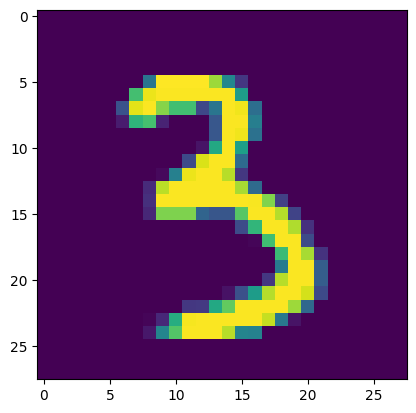

Label: 3
Model Prediction: 3
Confidence: 0.99
Loss: 0.01


Example image:


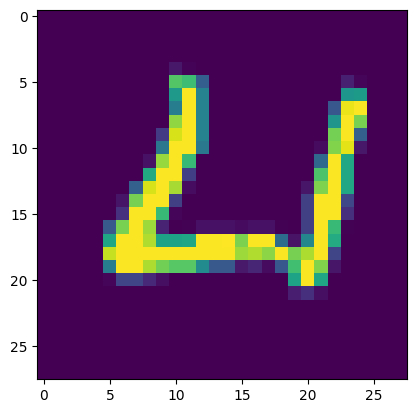

Label: 4
Model Prediction: 4
Confidence: 0.40
Loss: 0.91


Example image:


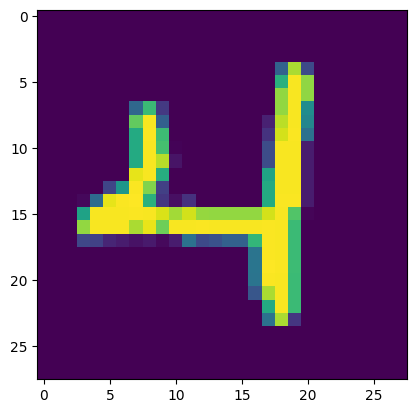

Label: 4
Model Prediction: 4
Confidence: 1.00
Loss: 0.00




In [57]:
import jax

# sample a few images from the test set
sample_batch = next(iter(test_ds))

sample_idxs = jax.random.choice(key=jax.random.PRNGKey(1), a=jnp.arange(len(sample_batch[0])), shape=(3,))

sample_imgs = sample_batch[0][sample_idxs].reshape(3, 28, 28)
sample_labels = sample_batch[1][sample_idxs]


for i in range(3):
    print(f"Example image:")
    plt.imshow(sample_imgs[i])
    plt.show()
    print(f"Label: {sample_labels[i]}")

    # get model output
    logits = model(sample_imgs[i].reshape(1, -1))
    probs = jax.nn.softmax(logits)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits.reshape(10, -1).squeeze(), sample_labels[i])
    pred = jnp.argmax(logits)

    # log preds and configdence
    print(f"Model Prediction: {pred}")
    print(f"Confidence: {probs[0][sample_labels[i]]:.2f}")
    print(f"Loss: {loss:.2f}")
    print("\n")